In [ ]:
# default_exp learner

In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.pipeline import *
from local.data.source import *
from local.data.core import *
from local.data.external import *
from local.notebook.showdoc import show_doc
from local.optimizer import *

# Learner

> Basic class for handling the training loop

## Synthetic data

We'll use the following for testing purposes (a basic linear regression problem):

In [ ]:
from torch.utils.data import TensorDataset

def synth_data(a=2, b=3, bs=16, n_trn=10, n_val=2):
    x_trn = torch.randn(bs*n_trn)
    y_trn = a*x_trn + b + 0.1*torch.randn(bs*n_trn)
    x_val = torch.randn(bs*n_val)
    y_val = a*x_val + b + 0.1*torch.randn(bs*n_val)
    train_ds = TensorDataset(x_trn, y_trn)
    valid_ds = TensorDataset(x_val, y_val)
    train_dl = TfmdDL(train_ds, bs=bs, shuffle=True)
    valid_dl = TfmdDL(valid_ds, bs=bs)
    return DataBunch(train_dl, valid_dl)

In [ ]:
class RegModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.a,self.b = nn.Parameter(torch.randn(1)),nn.Parameter(torch.randn(1))
    def forward(self, x): return x * self.a + self.b

## Callback - 

In [ ]:
#export core
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [ ]:
test_eq(camel2snake('ClassAreCamel'), 'class_are_camel')

In [ ]:
#export
@docs
class Callback():
    "Basic class handling tweaks of the training loop by changing a `Learner` in various events"
    order=0
    def __getattr__(self, k): return getattr(self.learn, k)
    
    @property
    def name(self):
        "Name of the `Callback`, camel-cased and with Callback removed"
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, event_name): getattr(self, event_name, noop)()
    
    _docs=dict(__call__="Call `self.{event_name}` if it's defined",
              __getattr__="Passthrough to get the attributes of `self.learn`",
              )

The training loop is defined in `Learner` a bit below and consists in a minimal set of instructions: looping through the data we:
- compute the output of the model from the input
- calculate a loss between this output and the desired target
- compute the gradients of this loss with respect to all the model parameters
- update the parameters accordingly
- zero all the gradients

Any tweak of this training loop is defined in a `Callback` to avoid over-complicating the code of the training loop, and to make it easy to mix and match different techniques (since they'll be defined in different callbacks). A callback can implement actions on the following events:

- `begin_fit`: called before doing anything, ideal for initial setup.
- `begin_epoch`: called at the beginning of each epoch, useful for any behavior you need to reset at each epoch.
- `begin_batch`: called at the beginning of each batch, just after drawing said batch. It can be used to do any setup necessary for the batch (like hyper-parameter scheduling) or to change the input/target before it goes in the model (change of the input with techniques like mixup for instance).
- `after_pred`: called after computing the output of the model on the batch. It can be used to change that output before it's fed to the loss.
- `after_loss`: called after the loss has been computed, but before the backward pass. It can be used to add any penalty to the loss (AR or TAR in RNN training for instance).
- `after_backward`: called after the backward pass, but before the update of the parameters. It can be used to do any change to the gradients before said update (gradient clipping for instance).
- `after_step`: called after the step and before the gradients are zeroed.
- `after_batch`: called at the end of a batch, for any clean-up before the next one.
- `begin_validate`: called at the beginning of the validation phase of an epoch, useful for any setup needed specifically for validation.
- `after_epoch`: called at the end of an epoch, for any clean-up before the next one.
- `after_fit`: called at the end of training, for final clean-up.

In [ ]:
show_doc(Callback.__call__)

<h4 id="<code>Callback.__call__</code>" class="doc_header"><code>Callback.__call__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Callback--" class="source_link" style="float:right">[source]</a></h4>

> <code>Callback.__call__</code>(**`event_name`**)

Call `self.{event_name}` if it's defined

In [ ]:
tst_cb = Callback()
tst_cb.call_me = lambda: print("maybe")
test_stdout(lambda: tst_cb("call_me"), "maybe")

In [ ]:
show_doc(Callback.__getattr__)

<h4 id="<code>Callback.__getattr__</code>" class="doc_header"><code>Callback.__getattr__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Callback--" class="source_link" style="float:right">[source]</a></h4>

> <code>Callback.__getattr__</code>(**`k`**)

Passthrough to get the attributes of `self.learn`

This is a shortcut to avoid having to write `self.learn.bla` for any `bla` attribute we seek, and just write `self.bla`.

In [ ]:
class TstLearner():
    def __init__(self, a): self.a = a

class TstCallback(Callback):
    def batch_begin(self): print(self.a)

learn,cb = TstLearner(1),TstCallback()
cb.learn = learn
test_stdout(lambda: cb('batch_begin'), "1")

Note that it only works to get the value of the attribute, if you want to change it, you have to manually access it with `self.learn.bla`. In the example below, `self.a += 1` creates an `a` attribute of 2 in the callback instead of setting the `a` of the learner to 2:

In [ ]:
class TstCallback(Callback):
    def batch_begin(self): self.a += 1

learn,cb = TstLearner(1),TstCallback()
cb.learn = learn
cb('batch_begin')
test_eq(cb.a, 2)
test_eq(cb.learn.a, 1)

A proper version needs to write `self.learn.a = self.a + 1`:

In [ ]:
class TstCallback(Callback):
    def batch_begin(self): self.learn.a = self.a + 1

learn,cb = TstLearner(1),TstCallback()
cb.learn = learn
cb('batch_begin')
test_eq(cb.learn.a, 2)

In [ ]:
show_doc(Callback.name)

<h4 id="<code><property object at 0x7fc6c7e09bd8></code>" class="doc_header"><code><property object at 0x7fc6c7e09bd8></code><a href="" class="source_link" style="float:right">[source]</a></h4>

Name of the [`Callback`](/learner.html#Callback), camel-cased and with Callback removed

In [ ]:
test_eq(TstCallback().name, 'tst')
class ComplicatedNameCallback(Callback): pass
test_eq(ComplicatedNameCallback().name, 'complicated_name')

### TrainEvalCallback -

In [ ]:
#export
class TrainEvalCallback(Callback):
    "`Callback` that tracks the number of iterations done and properly sets training/eval mode"
    def begin_fit(self):
        "Set the iter and epoch counters to 0"
        self.learn.train_iter,self.learn.pct_train = 0,0.
        
    def begin_batch(self):
        "On the first batch, put the model on the right device"
        if self.learn.train_iter == 0: self.model.to(find_device(self.xb))
    
    def after_batch(self):
        "Update the iter counter (in training mode)"
        if not self.training: return
        self.learn.pct_train += 1./(self.n_iter*self.n_epoch)
        self.learn.train_iter   += 1
        
    def begin_epoch(self):
        "Set the model in training mode"
        self.learn.pct_train=self.epoch/self.n_epoch
        self.model.train()
        self.learn.training=True

    def begin_validate(self):
        "Set the model in validation mode"
        self.model.eval()
        self.learn.training=False

In [ ]:
show_doc(TrainEvalCallback, title_level=3)

<h3 id="<code>class</code> <code>TrainEvalCallback</code>" class="doc_header"><code>class</code> <code>TrainEvalCallback</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#TrainEvalCallback--" class="source_link" style="float:right">[source]</a></h3>

> <code>TrainEvalCallback</code>() :: [`Callback`](/learner.html#Callback)

[`Callback`](/learner.html#Callback) that tracks the number of iterations done and properly sets training/eval mode

This `Callback` is automatically added in every `Learner` at initialization.

In [ ]:
#hide
#test of the TrainEvalCallback below in Learner.fit

In [ ]:
show_doc(TrainEvalCallback.begin_fit)

<h4 id="<code>TrainEvalCallback.begin_fit</code>" class="doc_header"><code>TrainEvalCallback.begin_fit</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#TrainEvalCallback--" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.begin_fit</code>()

Set the iter and epoch counters to 0

In [ ]:
show_doc(TrainEvalCallback.begin_batch)

<h4 id="<code>TrainEvalCallback.begin_batch</code>" class="doc_header"><code>TrainEvalCallback.begin_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#TrainEvalCallback--" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.begin_batch</code>()

On the first batch, put the model on the right device

In [ ]:
show_doc(TrainEvalCallback.after_batch)

<h4 id="<code>TrainEvalCallback.after_batch</code>" class="doc_header"><code>TrainEvalCallback.after_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#TrainEvalCallback--" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.after_batch</code>()

Update the iter counter (in training mode)

In [ ]:
show_doc(TrainEvalCallback.begin_epoch)

<h4 id="<code>TrainEvalCallback.begin_epoch</code>" class="doc_header"><code>TrainEvalCallback.begin_epoch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#TrainEvalCallback--" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.begin_epoch</code>()

Set the model in training mode

In [ ]:
show_doc(TrainEvalCallback.begin_validate)

<h4 id="<code>TrainEvalCallback.begin_validate</code>" class="doc_header"><code>TrainEvalCallback.begin_validate</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#TrainEvalCallback--" class="source_link" style="float:right">[source]</a></h4>

> <code>TrainEvalCallback.begin_validate</code>()

Set the model in validation mode

## Callbacks control flow

It happens that we may want to skip some of the steps of the training loop: in gradient accumulation, we don't aways want to do the step/zeroing of the grads for instance. During an LR finder test, we don't want to do the validation phase of an epoch. Or if we're training with a strategy of early stopping, we want to be able to completely interrupt the training loop.

This is made possible by raising specific exceptions the training loop will look for (and properly catch).

In [ ]:
#export
class CancelFitException  (Exception): pass
class CancelEpochException(Exception): pass
class CancelTrainException(Exception): pass
class CancelValidException(Exception): pass
class CancelBatchException(Exception): pass

CancelBatchException.__doc__ = "Skip the rest of this batch and go to `after_batch`"
CancelTrainException.__doc__ = "Skip the rest of the training part of the epoch and go to `after_epoch`"
CancelValidException.__doc__ = "Skip the rest of the validation part of the epoch and go to `after_epoch`"
CancelEpochException.__doc__ = "Skip the rest of this epoch and go to `after_epoch`"
CancelFitException  .__doc__ = "Interrupts training and go to `after_fit`"

In [ ]:
show_doc(CancelBatchException, title_level=3)

<h3 id="<code>class</code> <code>CancelBatchException</code>" class="doc_header"><code>class</code> <code>CancelBatchException</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Callbacks-control-flow" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelBatchException</code>() :: `Exception`

Skip the rest of this batch and go to `after_batch`

In [ ]:
show_doc(CancelTrainException, title_level=3)

<h3 id="<code>class</code> <code>CancelTrainException</code>" class="doc_header"><code>class</code> <code>CancelTrainException</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Callbacks-control-flow" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelTrainException</code>() :: `Exception`

Skip the rest of the training part of the epoch and go to `after_epoch`

In [ ]:
show_doc(CancelValidException, title_level=3)

<h3 id="<code>class</code> <code>CancelValidException</code>" class="doc_header"><code>class</code> <code>CancelValidException</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Callbacks-control-flow" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelValidException</code>() :: `Exception`

Skip the rest of the validation part of the epoch and go to `after_epoch`

In [ ]:
show_doc(CancelEpochException, title_level=3)

<h3 id="<code>class</code> <code>CancelEpochException</code>" class="doc_header"><code>class</code> <code>CancelEpochException</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Callbacks-control-flow" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelEpochException</code>() :: `Exception`

Skip the rest of this epoch and go to `after_epoch`

In [ ]:
show_doc(CancelFitException, title_level=3)

<h3 id="<code>class</code> <code>CancelFitException</code>" class="doc_header"><code>class</code> <code>CancelFitException</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Callbacks-control-flow" class="source_link" style="float:right">[source]</a></h3>

> <code>CancelFitException</code>() :: `Exception`

Interrupts training and go to `after_fit`

You can detect one of those exceptions occurred and add code that executes right after with the following events:
- `after_cancel_batch`: reached imediately after a `CancelBatchException` before proceeding to `after_batch`
- `after_cancel_train`: reached imediately after a `CancelTrainException` before proceeding to `after_epoch`
- `after_cancel_valid`: reached imediately after a `CancelValidException` before proceeding to `after_epoch`
- `after_cancel_epoch`: reached imediately after a `CancelEpochException` before proceeding to `after_epoch`
- `after_cancel_fit`: reached imediately after a `CancelFitException` before proceeding to `after_fit`

In [ ]:
#hide
#Full test of the control flow below, after the Learner class

## Learner -

In [ ]:
# export core
def trainable_params(m): 
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]

In [ ]:
m = nn.Linear(4,5)
test_eq(trainable_params(m), [m.weight, m.bias])
m.weight.requires_grad_(False)
test_eq(trainable_params(m), [m.bias])

In [ ]:
#export core
_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

In [ ]:
test_eq(camel2snake('ClassAreCamel'), 'class_are_camel')

In [ ]:
# export
event = SimpleNamespace(**{o:o for o in {
    'begin_fit', 'begin_epoch', 'begin_batch', 'after_pred', 'after_loss', 'after_backward', 
    'after_step', 'after_cancel_batch', 'after_batch', 'after_cancel_train', 'begin_validate',
    'after_cancel_validate', 'after_cancel_epoch', 'after_epoch', 'after_cancel_fit', 'after_fit'
}})

event.__doc__ = "Object containing all possible events as attributes to get tab-completion and typo-proofing"

In [ ]:
show_doc(event, name='event')

<h4 id="<code>event</code>" class="doc_header"><code>event</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Object containing all possible events as attributes to get tab-completion and typo-proofing

## Learner -

In [ ]:
# export
defaults.callbacks = [TrainEvalCallback]

class Learner():
    "Group together a `model`, some `data` and a `loss_func` to handle training"
    def __init__(self, model, data, loss_func, opt_func=SGD, lr=1e-2, splitter=trainable_params,
                 cbs=None, cb_funcs=None, metrics=None):
        self.model,self.data,self.loss_func = model,data,loss_func
        self.opt_func,self.lr,self.splitter,self.metrics = opt_func,lr,splitter,L(metrics)
        
        self.training,self.logger,self.opt = False,print,None
        self.cbs = L([])
        self.add_cbs(cbf() for cbf in L(defaults.callbacks))
        self.add_cbs(cbs)
        self.add_cbs(cbf() for cbf in L(cb_funcs))

    def add_cbs(self, cbs):
        "Add `cbs` to the list of `Callback` and register `self` as their learner"
        for cb in L(cbs): self.add_cb(cb)
            
    def add_cb(self, cb):
        "Add `cb` to the list of `Callback` and register `self` as their learner"
        cb.learn = self
        setattr(self, cb.name, cb)
        self.cbs.append(cb)

    def remove_cbs(self, cbs):
        "Remove `cbs` from the list of `Callback` and deregister `self` as their learner"
        for cb in L(cbs): self.remove_cb(cb)
            
    def remove_cb(self, cb):
        "Add `cb` from the list of `Callback` and deregister `self` as their learner"
        cb.learn = None
        setattr(self, cb.name, None)
        if cb in self.cbs: self.cbs.remove(cb)
            
    def one_batch(self, xb, yb, i=None):
        "Train or evaluate `self.model` on batch `(xb,yb)`"
        try:
            if i is not None: self.iter = i
            self.xb,self.yb = xb,yb;                        self('begin_batch')
            self.pred = self.model(self.xb);                self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb); self('after_loss')
            if not self.training: return
            self.loss.backward();                           self('after_backward')
            self.opt.step();                                self('after_step')
            self.opt.zero_grad()
        except CancelBatchException:                        self('after_cancel_batch')
        finally:                                            self('after_batch')

    def all_batches(self):
        "Train or evaluate `self.model` on all batches of `self.dl`"
        self.n_iter = len(self.dl)
        for i,(xb,yb) in enumerate(self.dl): self.one_batch(xb, yb, i)

    def do_begin_fit(self, n_epoch):
        "Prepare evertyhing for training `epochs` epochs"
        self.n_epoch,self.loss = n_epoch,tensor(0.)
        self('begin_fit')
    
    def do_epoch_train(self, epoch):
        "Execute the training part of the `epoch`-th epoch"
        self.epoch,self.dl = epoch,self.data.train_dl
        try:
            self('begin_epoch')
            self.all_batches()
        except CancelTrainException: self('after_cancel_train')
            
    def do_epoch_validate(self):
        "Execute the validation part of an epoch"
        try:
            self('begin_validate')
            with torch.no_grad(): 
                self.dl = self.data.valid_dl
                self.all_batches()
        except CancelValidException: self('after_cancel_validate')
            
    def fit(self, n_epoch, cbs=None, reset_opt=False):
        "Fit `self.model` for `epochs` using `cbs`. Optionally `reset_opt`."
        self.add_cbs(cbs)
        if reset_opt or not self.opt: self.opt = self.opt_func(self.splitter(self.model), lr=self.lr)
            
        try:
            self.do_begin_fit(n_epoch)
            for epoch in range(n_epoch):
                try:
                    self.do_epoch_train(epoch)
                    self.do_epoch_validate()
                except CancelEpochException: self('after_cancel_epoch')
                finally:                     self('after_epoch')
            
        except CancelFitException: self('after_cancel_fit')
        finally:
            self('after_fit')
            self.remove_cbs(cbs)

    def __call__(self, event_name):
        "Call `event_name` for all callbacks"
        assert hasattr(event, event_name)
        [cb(event_name) for cb in self.cbs.sorted("order")]

`opt_func` will be used to create an optimizer when `Learner.fit` is called, with `lr` as a learning rate. `splitter` is a function taht takes `self.model` and returns a list of parameter groups (or just one parameter group if there are no different parameter groups). The default is `trainable_params`, which returns all trainable parameters of the model.

`cbs` is one or a list of `Callback`s  to pass to the `Learner`, and `cb_funcs` is one or a list of functions returning a `Callback` that will be called at init. Each `Callback` is registered as an attribute of `Learner` (with camel case). At creation, all the callbacks in `defaults.callbacks` (`TrainEvalCallback` and `Recorder`) are associated to the `Learner`.

`metrics` is an optional list of metrics, that can be either functions or `Metric`s (see below).

In [ ]:
#Test init with callbacks
def synth_learner(n_trn=10, n_val=2, **kwargs):
    return Learner(RegModel(), synth_data(n_trn=n_trn,n_val=n_val), MSELossFlat(), **kwargs)

tst_learn = synth_learner()
test_eq(len(tst_learn.cbs), 1)
assert isinstance(tst_learn.cbs[0], TrainEvalCallback)
assert hasattr(tst_learn, ('train_eval'))

tst_learn = synth_learner(cbs=TstCallback())
test_eq(len(tst_learn.cbs), 2)
assert isinstance(tst_learn.cbs[1], TstCallback)
assert hasattr(tst_learn, ('tst'))

tst_learn = synth_learner(cb_funcs=TstCallback)
test_eq(len(tst_learn.cbs), 2)
assert isinstance(tst_learn.cbs[1], TstCallback)
assert hasattr(tst_learn, ('tst'))

### Training loop

In [ ]:
show_doc(Learner.fit)

<h4 id="<code>Learner.fit</code>" class="doc_header"><code>Learner.fit</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.fit</code>(**`n_epoch`**, **`cbs`**=*`None`*, **`reset_opt`**=*`False`*)

Fit `self.model` for `epochs` using `cbs`. Optionally `reset_opt`.

In [ ]:
#Integration test: training a few epochs should make the model better
learn = synth_learner(cb_funcs=TstCallback)
xb,yb = learn.data.one_batch()
init_loss = learn.loss_func(learn.model(xb), yb)
learn.fit(2)
assert learn.loss < init_loss

In [ ]:
#Test of TrainEvalCallback
class TestTrainEvalCallback(Callback):
    order = 1 #Runs after TrainEvalCallback
    def begin_fit(self): 
        test_eq([self.pct_train,self.train_iter], [0., 0])
        self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def begin_batch(self): test_eq(next(self.model.parameters()).device, find_device(self.xb))
    
    def after_batch(self):
        if self.training:
            test_eq(self.pct_train , self.old_pct_train+1/(self.n_iter*self.n_epoch))
            test_eq(self.train_iter, self.old_train_iter+1)
            self.old_pct_train,self.old_train_iter = self.pct_train,self.train_iter
    
    def begin_epoch(self):
        assert self.training and self.model.training
        test_eq(self.pct_train, self.epoch/self.n_epoch)
        self.old_pct_train = self.pct_train
    
    def begin_validate(self):
        assert not self.training and not self.model.training
        
learn = synth_learner(cb_funcs=TestTrainEvalCallback)
learn.fit(1)
#Check order is properly taken into account
learn.cbs = L(reversed(learn.cbs))

In [ ]:
show_doc(Learner.one_batch)

<h4 id="<code>Learner.one_batch</code>" class="doc_header"><code>Learner.one_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.one_batch</code>(**`xb`**, **`yb`**, **`i`**=*`None`*)

Train or evaluate `self.model` on batch `(xb,yb)`

This is an internal method called by `Learner.fit`. If passed, `i` is the index of this iteration in the epoch. In training method, this does a full training step on the batch (compute predictions, loss, gradients, update the model parameters and zero the gradients). In validation mode, it stops at the loss computation.

In [ ]:
# export
class VerboseCallback(Callback):
    "Callback that prints the name of each event called"
    def __call__(self, event_name):
        print(event_name)
        super().__call__(event_name)

In [ ]:
class TestOneBatch(VerboseCallback):
    def __init__(self, xb, yb, i):
        self.save_xb,self.save_yb,self.i = xb,yb,i
        self.old_pred,self.old_loss = None,tensor(0.)
        
    def begin_batch(self):
        self.old_a,self.old_b = self.model.a.data.clone(),self.model.b.data.clone()
        test_eq(self.iter,    self.i)
        test_eq(self.save_xb, self.xb)
        test_eq(self.save_yb, self.yb)
        if hasattr(self.learn, 'pred'): test_eq(self.pred, self.old_pred)
    
    def after_pred(self):
        self.old_pred = self.pred
        test_eq(self.pred, self.model.a.data * self.xb + self.model.b.data)
        test_eq(self.loss, self.old_loss)
    
    def after_loss(self):
        self.old_loss = self.loss
        test_eq(self.loss, self.loss_func(self.old_pred, self.save_yb))
        for p in self.model.parameters(): 
            if not hasattr(p, 'grad') or p.grad is not None: test_eq(p.grad, tensor([0.]))
    
    def after_backward(self):
        self.grad_a = (2 * self.xb * (self.pred.data - self.yb)).mean()
        self.grad_b = 2 * (self.pred.data - self.yb).mean()
        test_close(self.model.a.grad.data, self.grad_a)
        test_close(self.model.b.grad.data, self.grad_b)
        test_eq(self.model.a.data, self.old_a)
        test_eq(self.model.b.data, self.old_b)
        
    def after_step(self):
        test_close(self.model.a.data, self.old_a - self.lr * self.grad_a)
        test_close(self.model.b.data, self.old_b - self.lr * self.grad_b)
        self.old_a,self.old_b = self.model.a.data.clone(),self.model.b.data.clone()
        test_close(self.model.a.grad.data, self.grad_a)
        test_close(self.model.b.grad.data, self.grad_b)
    
    def after_batch(self):
        for p in self.model.parameters(): test_eq(p.grad, tensor([0.]))

In [ ]:
xb,yb = learn.data.one_batch()
learn = synth_learner(cbs=TestOneBatch(xb, yb, 42))
#Remove train/eval
learn.cbs = learn.cbs[1:]
#Setup
learn.loss,learn.training = tensor(0.),True
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
learn.model.train()
batch_events = ['begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step', 'after_batch']
test_stdout(lambda: learn.one_batch(xb, yb, 42), '\n'.join(batch_events))
test_stdout(lambda: learn.one_batch(xb, yb, 42), '\n'.join(batch_events)) #Check it works for a second batch

In [ ]:
show_doc(Learner.all_batches)

<h4 id="<code>Learner.all_batches</code>" class="doc_header"><code>Learner.all_batches</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.all_batches</code>()

Train or evaluate `self.model` on all batches of `self.dl`

In [ ]:
learn = synth_learner(n_trn=5, cbs=VerboseCallback())
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
with redirect_stdout(io.StringIO()): 
    learn.do_begin_fit(1)
    learn.epoch,learn.dl = 0,learn.data.train_dl
    learn('begin_epoch')
test_stdout(learn.all_batches, '\n'.join(batch_events * 5))
test_eq(learn.train_iter, 5)

valid_events = ['begin_batch', 'after_pred', 'after_loss', 'after_batch']
with redirect_stdout(io.StringIO()): 
    learn.dl = learn.data.valid_dl
    learn('begin_validate')
test_stdout(learn.all_batches, '\n'.join(valid_events * 2))
test_eq(learn.train_iter, 5)

In [ ]:
show_doc(Learner.do_begin_fit)

<h4 id="<code>Learner.do_begin_fit</code>" class="doc_header"><code>Learner.do_begin_fit</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.do_begin_fit</code>(**`n_epoch`**)

Prepare evertyhing for training `epochs` epochs

In [ ]:
learn = synth_learner(n_trn=5, cbs=VerboseCallback())
test_stdout(lambda: learn.do_begin_fit(42), 'begin_fit')
test_eq(learn.n_epoch, 42)
test_eq(learn.loss, tensor(0.))

In [ ]:
show_doc(Learner.do_epoch_train)

<h4 id="<code>Learner.do_epoch_train</code>" class="doc_header"><code>Learner.do_epoch_train</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.do_epoch_train</code>(**`epoch`**)

Execute the training part of the `epoch`-th epoch

In [ ]:
learn.opt = SGD(learn.model.parameters(), lr=learn.lr)
test_stdout(lambda: learn.do_epoch_train(2), '\n'.join(['begin_epoch'] + batch_events * 5))
test_eq(learn.epoch, 2)

In [ ]:
show_doc(Learner.do_epoch_validate)

<h4 id="<code>Learner.do_epoch_validate</code>" class="doc_header"><code>Learner.do_epoch_validate</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.do_epoch_validate</code>()

Execute the validation part of an epoch

In [ ]:
test_stdout(learn.do_epoch_validate, '\n'.join(['begin_validate'] + valid_events * 2))

### Callback handling

In [ ]:
show_doc(Learner.__call__)

<h4 id="<code>Learner.__call__</code>" class="doc_header"><code>Learner.__call__</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.__call__</code>(**`event_name`**)

Call `event_name` for all callbacks

In [ ]:
show_doc(Learner.add_cb)

<h4 id="<code>Learner.add_cb</code>" class="doc_header"><code>Learner.add_cb</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cb</code>(**`cb`**)

Add `cb` to the list of [`Callback`](/learner.html#Callback) and register `self` as their learner

In [ ]:
learn = synth_learner()
learn.add_cb(TestTrainEvalCallback())
test_eq(len(learn.cbs), 2)
assert isinstance(learn.cbs[1], TestTrainEvalCallback)
test_eq(learn.train_eval.learn, learn)

In [ ]:
show_doc(Learner.add_cbs)

<h4 id="<code>Learner.add_cbs</code>" class="doc_header"><code>Learner.add_cbs</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.add_cbs</code>(**`cbs`**)

Add `cbs` to the list of [`Callback`](/learner.html#Callback) and register `self` as their learner

In [ ]:
learn.add_cbs([TestTrainEvalCallback(), TestTrainEvalCallback()])
test_eq(len(learn.cbs), 4)

In [ ]:
show_doc(Learner.remove_cb)

<h4 id="<code>Learner.remove_cb</code>" class="doc_header"><code>Learner.remove_cb</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cb</code>(**`cb`**)

Add `cb` from the list of [`Callback`](/learner.html#Callback) and deregister `self` as their learner

In [ ]:
cb = learn.cbs[1]
learn.remove_cb(learn.cbs[1])
test_eq(len(learn.cbs), 3)
assert cb.learn is None
assert learn.test_train_eval is None

In [ ]:
show_doc(Learner.remove_cbs)

<h4 id="<code>Learner.remove_cbs</code>" class="doc_header"><code>Learner.remove_cbs</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Learner--" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.remove_cbs</code>(**`cbs`**)

Remove `cbs` from the list of [`Callback`](/learner.html#Callback) and deregister `self` as their learner

In [ ]:
cb = learn.cbs[1]
learn.remove_cbs(learn.cbs[1:])
test_eq(len(learn.cbs), 1)

When writing a callback, the following attributes of `Learner` are available:
- `model`: the model used for training/validation
- `data`: the underlying `DataBunch`
- `loss_func`: the loss function used
- `opt`: the optimizer used to udpate the model parameters
- `opt_func`: the function used to create the optimizer
- `cbs`: the list containing all `Callback`s
- `dl`: current `DataLoader` used for iteration
- `xb`: last input drawn from `self.dl` (potentially modified by callbacks)
- `yb`: last target drawn from `self.dl` (potentially modified by callbacks)
- `pred`: last predictions from `self.model` (potentially modified by callbacks)
- `loss`: last computed loss (potentially modified by callbacks)
- `n_epoch`: the number of epochs in this training
- `n_iter`: the number of iterations in the current `self.dl`
- `epoch`: the current epoch index (from 0 to `n_epoch-1`)
- `iter`: the current iteration index in `self.dl` (from 0 to `n_iter-1`)

The following attributes are added by `TrainEvalCallback` and should be available unless you went out of your way to remove that callback:

- `train_iter`: the number of training iterations done since the beginning of this training
- `pct_train`: from 0. to 1., the percentage of training iterations completed
- `training`:  flag to indicate if we're in training mode or not

### Control flow testing

In [ ]:
cycle_events = ['begin_fit', 'begin_epoch', 'begin_batch', 'after_pred', 'after_loss', 'after_backward', 
    'after_step', 'after_batch', 'begin_validate', 'begin_batch', 'after_pred', 'after_loss', 
    'after_batch', 'after_epoch', 'after_fit']
learn = synth_learner(n_trn=1, n_val=1)
test_stdout(lambda: learn.fit(1, cbs=VerboseCallback()), '\n'.join(cycle_events))

In [ ]:
class TestCancelCallback(VerboseCallback):
    def __init__(self, cancel_at=event.begin_batch, exception=CancelBatchException, train=None):
        def _interrupt(): 
            if train is None or train == self.training: raise exception()
        setattr(self, cancel_at, _interrupt)

In [ ]:
#test cancel batch
batch_events = ['begin_batch', 'after_pred', 'after_loss', 'after_backward', 'after_step']
for i,e in enumerate(batch_events):
    be = batch_events[:i+1] + ['after_cancel_batch', 'after_batch']
    bev = be if i <3 else batch_events[:3] + ['after_batch']
    cycle = cycle_events[:2] + be + ['begin_validate'] + bev + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(cancel_at=e)), '\n'.join(cycle))

#CancelBatchException not caught if thrown in any other event
for e in cycle_events:
    if e not in batch_events:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(cancel_at=e)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually

In [ ]:
#test cancel train
for i,e in enumerate(['begin_epoch'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 else []) + ['after_cancel_train']
    bev = batch_events[:3] + ['after_batch']
    cycle = cycle_events[:2] + be + ['begin_validate'] + bev + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelTrainException, True)), '\n'.join(cycle))

#CancelTrainException not caught if thrown in any other event
for e in cycle_events:
    if e not in ['begin_epoch'] + batch_events:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelTrainException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#test cancel valid
for i,e in enumerate(['begin_validate'] + batch_events[:3]):
    be = batch_events + ['after_batch']
    bev = batch_events[:i] + (['after_batch'] if i >=1 else []) + ['after_cancel_validate']
    cycle = cycle_events[:2] + be + ['begin_validate'] + bev + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelValidException, False)), '\n'.join(cycle))
    
#CancelValidException not caught if thrown in any other event
for e in cycle_events:
    if e not in ['begin_validate'] + batch_events[:3]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelValidException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#test cancel epoch
#In train
for i,e in enumerate(['begin_epoch'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 else []) 
    cycle = cycle_events[:2] + be + ['after_cancel_epoch'] + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelEpochException, True)), '\n'.join(cycle))
    
#In valid
for i,e in enumerate(['begin_validate'] + batch_events[:3]):
    be = batch_events + ['after_batch']
    bev = batch_events[:i] + (['after_batch'] if i >=1 else [])
    cycle = cycle_events[:2] + be + ['begin_validate'] + bev + ['after_cancel_epoch'] + cycle_events[-2:]
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelEpochException, False)), '\n'.join(cycle))
    
#CancelEpochException not caught if thrown in any other event
for e in ['begin_fit', 'after_epoch', 'after_fit']:
    if e not in ['begin_validate'] + batch_events[:3]:
        with redirect_stdout(io.StringIO()):
            cb = TestCancelCallback(e, CancelEpochException)
            test_fail(lambda: learn.fit(1, cbs=cb))
            learn.remove_cb(cb) #Have to remove it manually  

In [ ]:
#test cancel fit
#In begin fit
test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback('begin_fit', CancelFitException)), 
            '\n'.join(['begin_fit', 'after_cancel_fit', 'after_fit']))

#In train
for i,e in enumerate(['begin_epoch'] + batch_events):
    be = batch_events[:i] + (['after_batch'] if i >=1 else []) 
    cycle = cycle_events[:2] + be + ['after_epoch', 'after_cancel_fit', 'after_fit']
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelFitException, True)), '\n'.join(cycle))
    
#In valid
for i,e in enumerate(['begin_validate'] + batch_events[:3]):
    be = batch_events + ['after_batch']
    bev = batch_events[:i] + (['after_batch'] if i >=1 else [])
    cycle = cycle_events[:2] + be + ['begin_validate'] + bev + ['after_epoch', 'after_cancel_fit', 'after_fit']
    test_stdout(lambda: learn.fit(1, cbs=TestCancelCallback(e, CancelFitException, False)), '\n'.join(cycle))
    
#CancelEpochException not caught if thrown in any other event
with redirect_stdout(io.StringIO()):
    cb = TestCancelCallback('after_fit', CancelEpochException)
    test_fail(lambda: learn.fit(1, cbs=cb))
    learn.remove_cb(cb) #Have to remove it manually  

## Metrics -

In [ ]:
#export
@docs
class Metric():
    "Blueprint for defining a metric"
    def reset(self):             pass
    def accumulate(self, learn): pass
    @property
    def value(self): raise NotImplementedError
    
    @property
    def name(self):
        "Name of the `Metric`, camel-cased and with Metric removed"
        name = re.sub(r'Metric$', '', self.__class__.__name__)
        return camel2snake(name or 'metric')
    
    _docs = {'reset': "Reset inner state to prepare for new computation",
            'accumulate': "Use `learn` to update the state with new results",
            'value': "The value of the metric"
    }

In [ ]:
show_doc(Metric, title_level=3)

<h3 id="<code>class</code> <code>Metric</code>" class="doc_header"><code>class</code> <code>Metric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Metric</code>()

Blueprint for defining a metric

Metrics can be simple averages (like accuracy) but sometimes their computation is a little bit more complex and can't be averaged over batches (like precision or recall), which is why we need a special class for them. For simple functions that can be computed as averages over batches, we can use the class `AvgMetric`, otherwise you'll need to implement the following methods.

> Note: If your `Metric` has state depending on tensors, don't forget to store it on the CPU to avoid any potential memory leaks.

In [ ]:
show_doc(Metric.reset)

<h4 id="<code>Metric.reset</code>" class="doc_header"><code>Metric.reset</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.reset</code>()

Reset inner state to prepare for new computation

In [ ]:
show_doc(Metric.accumulate)

<h4 id="<code>Metric.accumulate</code>" class="doc_header"><code>Metric.accumulate</code><a href="https://github.com/fastai/fastai_docs/tree/master/dev/__main__.py#L5" class="source_link" style="float:right">[source]</a></h4>

> <code>Metric.accumulate</code>(**`learn`**)

Use `learn` to update the state with new results

In [ ]:
show_doc(Metric.value, name='Metric.value')

<h4 id="<code>Metric.value</code>" class="doc_header"><code>Metric.value</code><a href="" class="source_link" style="float:right">[source]</a></h4>

The value of the metric

In [ ]:
show_doc(Metric.name, name='Metric.name')

<h4 id="<code>Metric.name</code>" class="doc_header"><code>Metric.name</code><a href="" class="source_link" style="float:right">[source]</a></h4>

Name of the `Metric`, camel-cased and with Metric removed

In [ ]:
#export
class AvgMetric(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def __init__(self, func):  self.func = func
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += self.func(learn.pred, learn.yb).detach().cpu()*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count
    @property
    def name(self):  return self.func.__name__

In [ ]:
show_doc(AvgMetric, title_level=3)

<h3 id="<code>class</code> <code>AvgMetric</code>" class="doc_header"><code>class</code> <code>AvgMetric</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgMetric</code>(**`func`**) :: `Metric`

Average the values of `func` taking into account potential different batch sizes

In [ ]:
learn = synth_learner()
tst = AvgMetric(lambda x,y: (x-y).abs().mean())
t,u = torch.randn(100),torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.pred,learn.yb = t[i:i+25],u[i:i+25]
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.pred,learn.yb = t[splits[i]:splits[i+1]],u[splits[i]:splits[i+1]]
    tst.accumulate(learn)
test_close(tst.value, (t-u).abs().mean())

In [ ]:
#export
class AvgLoss(Metric):
    "Average the losses taking into account potential different batch sizes"
    def reset(self):           self.total,self.count = 0.,0
    def accumulate(self, learn):
        bs = find_bs(learn.yb)
        self.total += learn.loss.detach().cpu()*bs
        self.count += bs
    @property
    def value(self): return self.total/self.count

In [ ]:
show_doc(AvgLoss, title_level=3)

<h3 id="<code>class</code> <code>AvgLoss</code>" class="doc_header"><code>class</code> <code>AvgLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgLoss</code>() :: `Metric`

Average the losses taking into account potential different batch sizes

In [ ]:
tst = AvgLoss()
t = torch.randn(100)
tst.reset()
for i in range(0,100,25): 
    learn.yb,learn.loss = t[i:i+25],t[i:i+25].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

#With varying batch size
tst.reset()
splits = [0, 30, 50, 60, 100]
for i in range(len(splits )-1): 
    learn.yb,learn.loss = t[splits[i]:splits[i+1]],t[splits[i]:splits[i+1]].mean()
    tst.accumulate(learn)
test_close(tst.value, t.mean())

In [ ]:
#export
class AvgSmoothLoss(Metric):
    "Smooth average of the losses (exponentially weighted with `beta`)"
    def __init__(self, beta=0.98): self.beta = beta
    def reset(self):               self.count,self.val = 0,tensor(0.)
    def accumulate(self, learn):
        self.count += 1
        self.val = torch.lerp(learn.loss.detach().cpu(), self.val, self.beta) 
    @property
    def value(self): return self.val/(1-self.beta**self.count)

In [ ]:
show_doc(AvgSmoothLoss, title_level=3)

<h3 id="<code>class</code> <code>AvgSmoothLoss</code>" class="doc_header"><code>class</code> <code>AvgSmoothLoss</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AvgSmoothLoss</code>(**`beta`**=*`0.98`*) :: `Metric`

Smooth average of the losses (exponentially weighted with `beta`)

In [ ]:
tst = AvgSmoothLoss()
t = torch.randn(100)
tst.reset()
val = 0
for i in range(4): 
    learn.loss = t[i*25:(i+1)*25].mean()
    tst.accumulate(learn)
    val = val*0.98 + t[i*25:(i+1)*25].mean()*(1-0.98)
    test_close(val/(1-0.98**(i+1)), tst.value)

## Recorder --

In [ ]:
#export
class Recorder(Callback):
    order = 20
    "Callback that registers statistics (lr, loss and metrics) during training"
    def __init__(self, train_metrics=False, beta=0.98): 
        self.train_metrics = train_metrics
        self.loss,self.smooth_loss = AvgLoss(),AvgSmoothLoss(beta=beta)
        
    def begin_fit(self): 
        "Prepare state for training"
        self.lrs,self.losses,self.values = [],[],[]
        self.learn.metrics = [m if isinstance(m, Metric) else AvgMetric(m) for m in self.metrics]
        self.smooth_loss.reset()

    def after_batch(self):
        "Update all metrics and records lr and smooth loss in training"
        mets = [self.smooth_loss, self.loss] if self.training else [self.loss]
        if self.train_metrics or not self.training: mets += self.metrics
        for met in mets: met.accumulate(self.learn)
        if not self.training: return
        self.lrs.append(self.opt.hypers[-1]['lr'])
        self.losses.append(self.smooth_loss.value)
        self.learn.smooth_loss = self.smooth_loss.value
    
    def begin_epoch(self): [m.reset() for m in [self.loss] + self.metrics]
            
    def begin_validate(self):
        "Log training loss and metric values on the training set (if `train_metrics=True`)"
        mets = [self.loss] + (self.metrics if self.train_metrics else [])
        self.log = [m.value for m in mets]
        for m in mets: m.reset()
    
    def after_epoch(self):
        "Log validation loss and metric values on the validation set"
        self.log += [m.value for m in [self.loss] + self.metrics]
        self.values.append(self.log)
        self.logger(self.log)

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)
        
    def plot(self, skip_last=0):
        "Plot losses vs learning rates with a log scale, optionally `skip_last` values"
        losses = [o.item() for o in self.losses]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(self.lrs[:n], losses[:n])
    
    _docs = {"begin_epoch": "Reset loss and metrics state",
             "plot_lr": "Plot the learning rates",
             "plot_loss": "Plot the losses"}
    
defaults.callbacks = [TrainEvalCallback, Recorder]

By default, metrics are computed on the validation set only, although that can be changed with `training_metrics=True`. `beta` is the weight used to compute the exponentially weighted average of the losses (which gives the `smooth_loss` attribute to `Learner`).

In [ ]:
class TestRecorderCallback(Callback):
    order = 30
    def begin_fit(self): 
        self.train_metrics,self.beta = self.recorder.train_metrics,self.recorder.smooth_loss.beta
        for m in self.metrics: assert isinstance(m, Metric)
        test_eq(self.recorder.smooth_loss.val, 0.)
        #To test what the recorder logs, we use a custom logger function.
        self.learn.logger = self.test_log
        self.old_smooth,self.count = tensor(0.),0
    
    def after_batch(self):
        if self.training:
            self.count += 1
            test_eq(len(self.recorder.lrs), self.count)
            test_eq(self.recorder.lrs[-1], self.opt.hypers[-1]['lr'])
            test_eq(len(self.recorder.losses), self.count)
            smooth = (1 - self.beta**(self.count-1)) * self.old_smooth * self.beta + self.loss * (1-self.beta)
            smooth /= 1 - self.beta**self.count
            test_close(self.recorder.losses[-1], smooth, eps=1e-4)
            test_close(self.smooth_loss, smooth, eps=1e-4)
            self.old_smooth = self.smooth_loss
        self.bs += find_bs(self.yb)
        test_eq(self.recorder.loss.count, self.bs)
        if self.train_metrics or not self.training: 
            for m in self.metrics: test_eq(m.count, self.bs)
        self.losses.append(self.loss.detach().cpu())
    
    def begin_epoch(self): 
        self.bs = 0
        self.losses = []
        for m in [self.recorder.loss] + self.metrics: test_eq(m.count, self.bs)
            
    def begin_validate(self):
        self.bs = 0
        for m in [self.recorder.loss] + self.metrics: test_eq(m.count, self.bs)
        res = tensor(self.losses).mean()
        self.log = [res, res] if self.train_metrics else [res]
        test_eq(self.log, self.recorder.log)
        self.losses = []
    
    def test_log(self, log):
        res = tensor(self.losses).mean()
        self.log += [res, res]
        test_eq(log, self.log)

In [ ]:
learn = synth_learner(n_trn=5, metrics = tst_metric, cbs=TestRecorderCallback())
learn.fit(1)
learn.recorder.train_metrics=True
learn.fit(1)

### Callback internals

In [ ]:
show_doc(Recorder.begin_fit)

<h4 id="<code>Recorder.begin_fit</code>" class="doc_header"><code>Recorder.begin_fit</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_fit</code>()

Prepare state for training

In [ ]:
show_doc(Recorder.begin_epoch)

<h4 id="<code>Recorder.begin_epoch</code>" class="doc_header"><code>Recorder.begin_epoch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_epoch</code>()



In [ ]:
show_doc(Recorder.begin_validate)

<h4 id="<code>Recorder.begin_validate</code>" class="doc_header"><code>Recorder.begin_validate</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.begin_validate</code>()

Log training loss and metric values on the training set (if `train_metrics=True`)

In [ ]:
show_doc(Recorder.after_batch)

<h4 id="<code>Recorder.after_batch</code>" class="doc_header"><code>Recorder.after_batch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_batch</code>()

Update all metrics and records lr and smooth loss in training

In [ ]:
show_doc(Recorder.after_epoch)

<h4 id="<code>Recorder.after_epoch</code>" class="doc_header"><code>Recorder.after_epoch</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.after_epoch</code>()

Log validation loss and metric values on the validation set

### Ploting tools

In [ ]:
show_doc(Recorder.plot)

<h4 id="<code>Recorder.plot</code>" class="doc_header"><code>Recorder.plot</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.plot</code>(**`skip_last`**=*`0`*)

Plot losses vs learning rates with a log scale, optionally `skip_last` values

This is used in conjunction with `LRFinder` to determine a good learning rate.

In [ ]:
show_doc(Recorder.plot_lr)

<h4 id="<code>Recorder.plot_lr</code>" class="doc_header"><code>Recorder.plot_lr</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.plot_lr</code>()



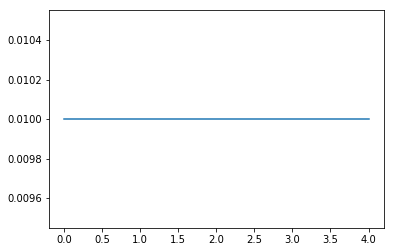

In [ ]:
#hide
learn.recorder.plot_lr()

In [ ]:
show_doc(Recorder.plot_loss)

<h4 id="<code>Recorder.plot_loss</code>" class="doc_header"><code>Recorder.plot_loss</code><a href="https://nbviewer.jupyter.org/github/fastai/fastai_docs/blob/master/dev/12_learner.ipynb#Recorder---" class="source_link" style="float:right">[source]</a></h4>

> <code>Recorder.plot_loss</code>()



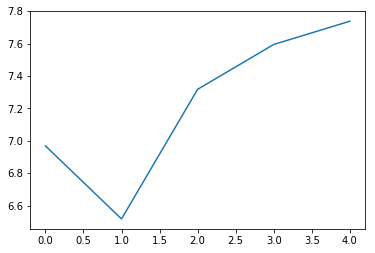

In [ ]:
#hide
learn.recorder.plot_loss()

## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 02_data_pipeline.ipynb.
Converted 03_data_external.ipynb.
Converted 04_data_core.ipynb.
Converted 05_data_source.ipynb.
Converted 06_vision_core.ipynb.
Converted 07_pets_tutorial.ipynb.
Converted 08_augmentation.ipynb.
Converted 10_layers.ipynb.
Converted 11_optimizer.ipynb.
Converted 12_learner.ipynb.
Converted 90_notebook_core.ipynb.
Converted 91_notebook_export.ipynb.
Converted 92_notebook_showdoc.ipynb.
Converted 93_notebook_export2html.ipynb.
Converted 94_index.ipynb.
